# **Importamos dependencias**

In [66]:
# Importar SparkSession para iniciar la aplicación Spark
from pyspark.sql import SparkSession

# Importar el módulo de funciones de Spark SQL para usar funciones de DataFrame
from pyspark.sql import functions as F

# Importar tipos puede ser útil para definir esquemas o hacer casting explícito
from pyspark.sql.types import StringType, IntegerType, DateType, DoubleType

from pyspark.sql.functions import dayofmonth

import pandas as pd

# Para graficar
import matplotlib.pyplot as plt
import seaborn as sns

# **Iniciamos la sesión**

In [51]:
# 2. Crear la SparkSession
spark = SparkSession.builder \
    .appName("MetroDataProcessing") \
    .getOrCreate()

# **Cargamos los datos**

In [52]:
df = spark.read.csv('/content/drive/MyDrive/Apuntes/Octavo semestre/Programación paralela y concurrente/Prácticas/Práctica 2/metro.csv', header=True)

In [53]:
# --- Le damos un vistaso a nuestros datos ---
df.show(5, truncate=False)

+----------+----+-----+-------+-------------------+---------+--------------+------------+
|fecha     |anio|mes  |linea  |estacion           |afluencia|temporal_fecha|..anio_fecha|
+----------+----+-----+-------+-------------------+---------+--------------+------------+
|2010-01-01|2010|Enero|Linea 1|Zaragoza           |20227    |2010-01       |2010        |
|2010-01-01|2010|Enero|Linea 1|Isabel la CatÃ³lica|6487     |2010-01       |2010        |
|2010-01-01|2010|Enero|Linea 1|Moctezuma          |10304    |2010-01       |2010        |
|2010-01-01|2010|Enero|Linea 1|Pino SuÃ¡rez       |8679     |2010-01       |2010        |
|2010-01-01|2010|Enero|Linea 1|GÃ³mez FarÃ­as     |19499    |2010-01       |2010        |
+----------+----+-----+-------+-------------------+---------+--------------+------------+
only showing top 5 rows



# **Exploración de datos**

### **Limpieza de datos**

Podemos ver que, tenemos una columna que (aparentemente) no nos sirve. La cual es 'anio_fecha'

In [54]:
df = df.drop('..anio_fecha')

In [55]:
# --- Vemos los cambios que hice ---
df.show(5, truncate=False)

+----------+----+-----+-------+-------------------+---------+--------------+
|fecha     |anio|mes  |linea  |estacion           |afluencia|temporal_fecha|
+----------+----+-----+-------+-------------------+---------+--------------+
|2010-01-01|2010|Enero|Linea 1|Zaragoza           |20227    |2010-01       |
|2010-01-01|2010|Enero|Linea 1|Isabel la CatÃ³lica|6487     |2010-01       |
|2010-01-01|2010|Enero|Linea 1|Moctezuma          |10304    |2010-01       |
|2010-01-01|2010|Enero|Linea 1|Pino SuÃ¡rez       |8679     |2010-01       |
|2010-01-01|2010|Enero|Linea 1|GÃ³mez FarÃ­as     |19499    |2010-01       |
+----------+----+-----+-------+-------------------+---------+--------------+
only showing top 5 rows



In [56]:
# --- Vemos el tipo de datos que hay ---
df.printSchema()

root
 |-- fecha: string (nullable = true)
 |-- anio: string (nullable = true)
 |-- mes: string (nullable = true)
 |-- linea: string (nullable = true)
 |-- estacion: string (nullable = true)
 |-- afluencia: string (nullable = true)
 |-- temporal_fecha: string (nullable = true)



In [57]:
# --- Cambiamos el tipo de dato de la columna 'fecha' ---
df = df.withColumn("fecha", df["fecha"].cast(DateType()))

In [58]:
# --- Cambiamos el tipo de dato de la columna 'afluencia' ---
df = df.withColumn('afluencia', df['afluencia'].cast(IntegerType()))

In [59]:
df.printSchema()

root
 |-- fecha: date (nullable = true)
 |-- anio: string (nullable = true)
 |-- mes: string (nullable = true)
 |-- linea: string (nullable = true)
 |-- estacion: string (nullable = true)
 |-- afluencia: integer (nullable = true)
 |-- temporal_fecha: string (nullable = true)



Creamos una nueva columna que tiene el día del mes

In [60]:
df = df.withColumn("dia", F.dayofmonth(F.col("fecha")))

Creamos una nueva columna que tiene el día de la semana

In [61]:
# 1 = Domingo
# 2 = Lunes
# 3 = Martes
# 4 = Miercoles
# 5 = Jueves
# 6 = Viernes
# 7 = Sábado

df= df.withColumn("dia_semana",F.dayofweek(F.col('fecha')))

In [62]:
df.printSchema()

root
 |-- fecha: date (nullable = true)
 |-- anio: string (nullable = true)
 |-- mes: string (nullable = true)
 |-- linea: string (nullable = true)
 |-- estacion: string (nullable = true)
 |-- afluencia: integer (nullable = true)
 |-- temporal_fecha: string (nullable = true)
 |-- dia: integer (nullable = true)
 |-- dia_semana: integer (nullable = true)



In [63]:
df.show(5, truncate=False)

+----------+----+-----+-------+-------------------+---------+--------------+---+----------+
|fecha     |anio|mes  |linea  |estacion           |afluencia|temporal_fecha|dia|dia_semana|
+----------+----+-----+-------+-------------------+---------+--------------+---+----------+
|2010-01-01|2010|Enero|Linea 1|Zaragoza           |20227    |2010-01       |1  |6         |
|2010-01-01|2010|Enero|Linea 1|Isabel la CatÃ³lica|6487     |2010-01       |1  |6         |
|2010-01-01|2010|Enero|Linea 1|Moctezuma          |10304    |2010-01       |1  |6         |
|2010-01-01|2010|Enero|Linea 1|Pino SuÃ¡rez       |8679     |2010-01       |1  |6         |
|2010-01-01|2010|Enero|Linea 1|GÃ³mez FarÃ­as     |19499    |2010-01       |1  |6         |
+----------+----+-----+-------+-------------------+---------+--------------+---+----------+
only showing top 5 rows



### **Visualización**

In [71]:
# --- Obtenemos los datos que necesito, usando un groupBy
afluencia_por_anio = df.groupBy('anio') \
                     .agg(F.sum('afluencia')).alias('afluencia_por_anio') \
                     .orderBy('anio')

afluencia_por_anio.show()

+----+--------------+
|anio|sum(afluencia)|
+----+--------------+
|2010|    1530248597|
|2011|    1594903897|
|2012|    1608865175|
|2013|    1684936618|
|2014|    1614333594|
|2015|    1623828642|
|2016|    1662562714|
|2017|    1615652411|
|2018|    1647475013|
|2019|    1594651279|
|2020|     894224342|
|2021|     794299549|
|2022|    1030108295|
|2023|    1115299291|
|2024|    1171859109|
|2025|     295691176|
+----+--------------+



In [72]:
# --- Lo hacemos un dataframe (ya es mucho más pequeño) para graficar ---
afluencia_por_anio = afluencia_por_anio.toPandas()

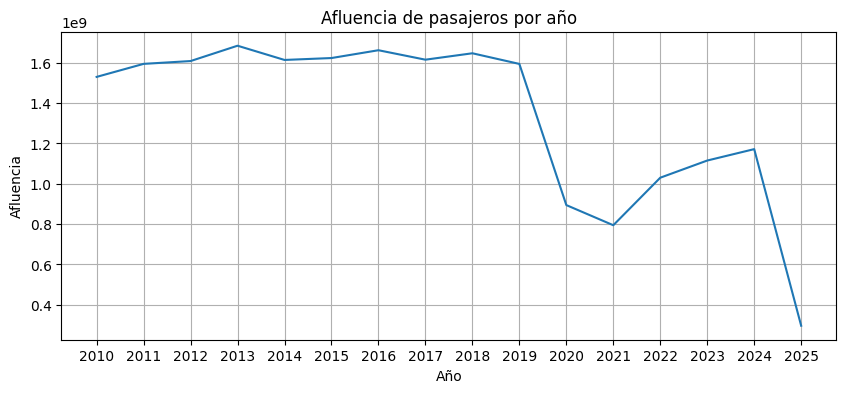

In [75]:
# --- Graficamos ---

plt.figure(figsize=(10, 4))
sns.lineplot(x = afluencia_por_anio['anio'], y = afluencia_por_anio['sum(afluencia)'])
plt.title('Afluencia de pasajeros por año')
plt.xlabel('Año')
plt.ylabel('Afluencia')
plt.grid(True)
plt.show()

Aunque pueda parecer que en 2025 no haya muchos pasajeros, es una comparación injusta, pues los datos llegan (si mal no recuerdo) hasta el 15 de abril.

<br>

Lo que si es evidente, es que antes la cantidad de pasajeros se mantenía relativamente constante a lo largo del tiempo, pero cuando pasó lo del Covid bajó muchísimo.

Ahora, vamos a agrupar por la afluencia por la línea

In [82]:
# --- Obtenemos los datos que necesito, usando un groupBy
afluencia_por_linea = df.groupBy('linea') \
                     .agg(F.sum('afluencia')).alias('afluencia_por_linea') \
                     .orderBy('linea')

afluencia_por_linea.show()

+---------+--------------+
|    linea|sum(afluencia)|
+---------+--------------+
|  Linea 1|    2819975239|
| Linea 12|     925984886|
|  Linea 2|    3377332442|
|  Linea 3|    2775837035|
|  Linea 4|     358201234|
|  Linea 5|     959403666|
|  Linea 6|     595055297|
|  Linea 7|    1196482827|
|  Linea 8|    1659303469|
|  Linea 9|    1342267506|
|  Linea A|    1110998826|
|  Linea B|    1896450326|
| LÃ­nea 1|     261051406|
|LÃ­nea 12|      34766602|
| LÃ­nea 2|     371135216|
| LÃ­nea 3|     345263505|
| LÃ­nea 4|      50325405|
| LÃ­nea 5|     125135576|
| LÃ­nea 6|      75905680|
| LÃ­nea 7|     152266394|
+---------+--------------+
only showing top 20 rows



Seguramente por error de capturas en los datos, tenemos inconruencias en las líneas. Así que vamos a estandarizar esto.

In [83]:
mapa_reemplazo = {
    # Nombres raros
    'LÃ\xadnea 1': 'Linea 1',
    'LÃ\xadnea 12': 'Linea 12',
    'LÃ\xadnea 2': 'Linea 2',
    'LÃ\xadnea 3': 'Linea 3',
    'LÃ\xadnea 4': 'Linea 4',
    'LÃ\xadnea 5': 'Linea 5',
    'LÃ\xadnea 6': 'Linea 6',
    'LÃ\xadnea 7': 'Linea 7',
    'LÃ\xadnea 8': 'Linea 8',
    'LÃ\xadnea 9': 'Linea 9',
    'LÃ\xadnea A': 'Linea A',
    'LÃ\xadnea B': 'Linea B',

    # Nombres con acentos
    'Línea 1': 'Linea 1',
    'Línea 12': 'Linea 12',
    'Línea 2': 'Linea 2',
    'Línea 3': 'Linea 3',
    'Línea 4': 'Linea 4',
    'Línea 5': 'Linea 5',
    'Línea 6': 'Linea 6',
    'Línea 7': 'Linea 7',
    'Línea 8': 'Linea 8',
    'Línea 9': 'Linea 9',
    'Línea A': 'Linea A',
    'Línea B': 'Linea B'
}

In [84]:
items_list = [elem for pair in mapa_reemplazo.items() for elem in pair]
mapping_expr = F.create_map(*[F.lit(x) for x in items_list])

df_corregido = df.withColumn("linea_corregida",
    F.coalesce(mapping_expr[F.col("linea")], F.col("linea"))
)

df_final = df_corregido.drop("linea").withColumnRenamed("linea_corregida", "linea")


df_final.select("linea").distinct().orderBy("linea").show(30, truncate=False)

+--------+
|linea   |
+--------+
|Linea 1 |
|Linea 12|
|Linea 2 |
|Linea 3 |
|Linea 4 |
|Linea 5 |
|Linea 6 |
|Linea 7 |
|Linea 8 |
|Linea 9 |
|Linea A |
|Linea B |
+--------+



In [85]:
afluencia_por_linea = df_final.groupBy('linea') \
                              .agg(F.sum('afluencia').alias('afluencia_total')) \
                              .orderBy('linea')

afluencia_por_linea.show(truncate=False)

+--------+---------------+
|linea   |afluencia_total|
+--------+---------------+
|Linea 1 |3090889278     |
|Linea 12|974097615      |
|Linea 2 |3779406787     |
|Linea 3 |3148400150     |
|Linea 4 |412422284      |
|Linea 5 |1094294685     |
|Linea 6 |677361083      |
|Linea 7 |1362055912     |
|Linea 8 |1932768160     |
|Linea 9 |1545513409     |
|Linea A |1282645907     |
|Linea B |2179084432     |
+--------+---------------+



In [90]:
# Lo transformamos en un df para poder graficar
afluencia_por_linea = afluencia_por_linea.toPandas()

Ahora si, ya podemos graficar

In [93]:
afluencia_por_linea

,linea,afluencia_total
0,Linea 1,3090889278
1,Linea 12,974097615
2,Linea 2,3779406787
3,Linea 3,3148400150
4,Linea 4,412422284
5,Linea 5,1094294685
6,Linea 6,677361083
7,Linea 7,1362055912
8,Linea 8,1932768160
9,Linea 9,1545513409


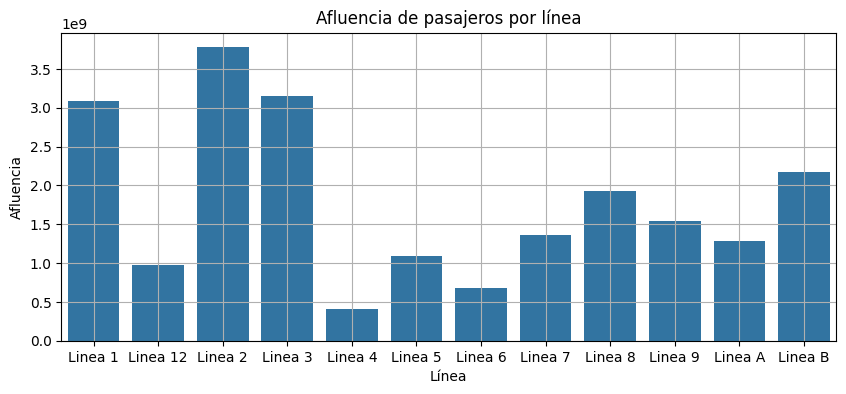

In [103]:
# --- Graficamos ---

plt.figure(figsize=(10, 4))
sns.barplot(x = afluencia_por_linea['linea'], y = afluencia_por_linea['afluencia_total'])
plt.title('Afluencia de pasajeros por línea')
plt.xlabel('Línea')
plt.ylabel('Afluencia')
plt.grid(True)
plt.show()

# **Análisis**

### **Afluencia por el mes**

Si bien en este conjunto de datos no tenemos horarios, si tenemos fechas, así que vamos a hacer el análisis sobre esas fechas.


In [111]:
fecha_inicio_covid = "2020-03-15" # Inicio del COIVD
fecha_fin_covid    = "2021-12-31" # Fin del COVID


# No vamos a tomar en cuenta el periodo del COVID
df_filtrado = df.filter(
    (F.col("fecha") < F.lit(fecha_inicio_covid).cast('date')) |
    (F.col("fecha") > F.lit(fecha_fin_covid).cast('date'))
)


# Sumamos las afluencias diarias
total_diario_df_filtrado = df_filtrado.groupBy("fecha") \
                                      .agg(F.sum("afluencia").alias("afluencia_total_ese_dia"))

In [112]:
# Calculamos el promedio mensual
promedio_total_por_mes_filtrado = total_diario_df_filtrado.withColumn("mes_numero", F.month(F.col("fecha"))) \
                                                          .groupBy("mes_numero") \
                                                          .agg(F.avg("afluencia_total_ese_dia").alias("promedio_afluencia_total_diaria")) \
                                                          .orderBy("mes_numero")

promedio_total_por_mes_filtrado.show(12)

+----------+-------------------------------+
|mes_numero|promedio_afluencia_total_diaria|
+----------+-------------------------------+
|         1|             3843651.9096774193|
|         2|             4122280.3466981133|
|         3|              4012611.276785714|
|         4|              4002967.869230769|
|         5|             4148121.6972704716|
|         6|             4095727.3743589744|
|         7|             3933350.3498759307|
|         8|               4257770.23573201|
|         9|             4082094.8871794874|
|        10|              4355954.627791563|
|        11|              4295214.853846154|
|        12|              4032011.094292804|
+----------+-------------------------------+



In [113]:
# Convertimos de df de Spark a Pandas
promedio_total_por_mes_filtrado_pandas = promedio_total_por_mes_filtrado.toPandas()

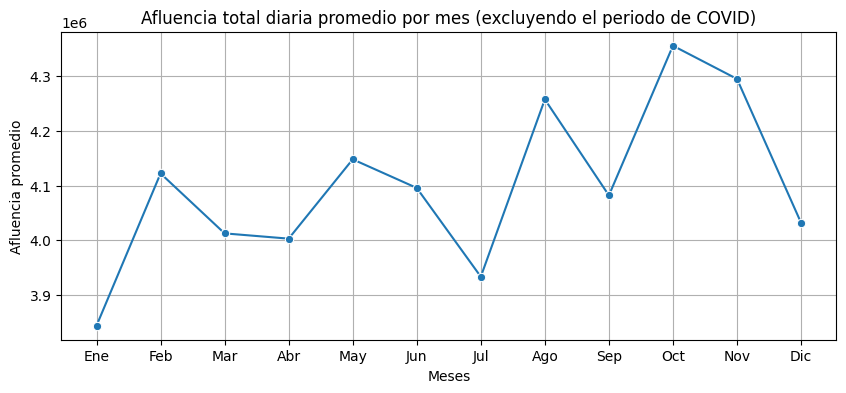

In [115]:
# --- Graficamos ---

plt.figure(figsize=(10, 4))
sns.lineplot(data=promedio_total_por_mes_filtrado_pandas,
             x='mes_numero',
             y='promedio_afluencia_total_diaria',
             marker='o')

plt.title('Afluencia total diaria promedio por mes (excluyendo el periodo de COVID)')
plt.xlabel('Meses')
plt.ylabel('Afluencia promedio')
plt.xticks(ticks=range(1, 13), labels=['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic'])
plt.grid(True)
plt.show()

Se puede ver, que en general, que los primeros 7 meses del año la afluencia es más baja que en los últimos 5 meses del año.

En particular, hay un decenso notorio en el mes de Julio, lo cual pienso que se debe a las vacaciones de verano (y la consecuente disminución de alumnos en las calles a todas horas). De hecho, pienso que es probable que también por esa razón hay una baja de afluencia en los meses de Diciembre-Enero (por las vacaciones de invierno).

### **Análisis por el día de la semana**

Veamos las estaciones que hay

In [124]:
estaciones = list(df.select('estacion').distinct().collect())
estaciones

[Row(estacion='Panteones'),
 Row(estacion='Universidad'),
 Row(estacion='Tepito'),
 Row(estacion='Atlalilco'),
 Row(estacion='Iztacalco'),
 Row(estacion='Ciudad Azteca'),
 Row(estacion='Autobuses del Norte'),
 Row(estacion='Plaza AragÃ³n'),
 Row(estacion='Bondojito'),
 Row(estacion='Insurgentes'),
 Row(estacion='Candelaria'),
 Row(estacion='Tlatelolco'),
 Row(estacion='San Antonio'),
 Row(estacion='Olivos'),
 Row(estacion='Eugenia'),
 Row(estacion='Bosque de AragÃ³n'),
 Row(estacion='Romero Rubio'),
 Row(estacion='ZÃ³calo/Tenochtitlan'),
 Row(estacion='Tacuba'),
 Row(estacion='Guerrero'),
 Row(estacion='Hospital 20 de Noviembre'),
 Row(estacion='UAM-Azcapotzalco'),
 Row(estacion='Xola'),
 Row(estacion='Pino SuÃ¡rez'),
 Row(estacion='PantitlÃ¡n'),
 Row(estacion='Canal del Norte'),
 Row(estacion='San JoaquÃ\xadn'),
 Row(estacion='TalismÃ¡n'),
 Row(estacion='Popotla'),
 Row(estacion='Patriotismo'),
 Row(estacion='Hidalgo'),
 Row(estacion='Norte 45'),
 Row(estacion='General Anaya'),
 Row(e

Probablemente hay estaciones repetidas por algún error de captura (tal como pasó con las líneas), y aquí si le pedí a ChatGPT que hiciera la corrección, solo le pasé como ejemplo lo que hice con las líneas del metro. Y se le pedí a el porque era considerar un montón de casos, y no quería hacer eso de forma manual

In [149]:
from pyspark.sql import functions as F

# --- PASO 1: Define la información para la columna 'estacion' ---

columna_a_limpiar = 'estacion'

nuevo_mapa_reemplazo = {
    # --- Errores de Codificación Detectados ---
    'Plaza AragÃ³n': 'Plaza Aragón',
    'Bosque de AragÃ³n': 'Bosque de Aragón',
    'ZÃ³calo/Tenochtitlan': 'Zócalo/Tenochtitlan',
    'Pino SuÃ¡rez': 'Pino Suárez',
    'PantitlÃ¡n': 'Pantitlán',
    'San JoaquÃ\xadn': 'San Joaquín',            # Corregido Joaquín
    'TalismÃ¡n': 'Talismán',
    'AragÃ³n': 'Aragón',
    'San Juan de LetrÃ¡n': 'San Juan de Letrán',
    'AgrÃ\xadcola Oriental': 'Agrícola Oriental', # Corregido Agrícola
    'TasqueÃ±a': 'Tasqueña',
    'RÃ\xado de los Remedios': 'Río de los Remedios',
    'CoyoacÃ¡n': 'Coyoacán',
    'MartÃ\xadn Carrera': 'Martín Carrera',
    'JuanacatlÃ¡n': 'Juanacatlán',
    'Instituto del PetrÃ³leo': 'Instituto del Petróleo',
    'NezahualcÃ³yotl': 'Nezahualcóyotl',
    'PolitÃ©cnico': 'Politécnico',
    'MÃºzquiz': 'Múzquiz',
    'PeÃ±Ã³n Viejo': 'Peñón Viejo',            # Encoding con V Mayúscula
    'PeÃ±Ã³n viejo': 'Peñón Viejo',            # Encoding con v minúscula (visto cerca del final)
    'JuÃ¡rez': 'Juárez',
    'NiÃ±os HÃ©roes': 'Niños Héroes',
    'Valle GÃ³mez': 'Valle Gómez',
    'ZapotitlÃ¡n': 'Zapotitlán',
    'TlÃ¡huac': 'Tláhuac',
    'LÃ¡zaro CÃ¡rdenas': 'Lázaro Cárdenas',
    'FerrerÃ\xada/Arena Ciudad de MÃ©xico': 'Ferrería/Arena Ciudad de México',
    'Aquiles SerdÃ¡n': 'Aquiles Serdán',
    'Deportivo OceanÃ\xada': 'Deportivo Oceanía',
    'OceanÃ\xada': 'Oceanía',
    'EtiopÃ\xada/Plaza de la Transparencia': 'Etiopía/Plaza de la Transparencia',
    'CuitlÃ¡huac': 'Cuitláhuac',
    'TezozÃ³moc': 'Tezozómoc',
    'CulhuacÃ¡n': 'Culhuacán',
    'RevoluciÃ³n': 'Revolución',
    'San LÃ¡zaro': 'San Lázaro',
    'San AndrÃ©s TomatlÃ¡n': 'San Andrés Tomatlán',
    'Terminal AÃ©rea': 'Terminal Aérea',
    'CuauhtÃ©moc': 'Cuauhtémoc',
    'GÃ³mez FarÃ\xadas': 'Gómez Farías',        # Encoding Y Typo (Faríadas)
    'GÃ³mez Farias': 'Gómez Farías',           # Encoding sin acento en i (visto al final)
    'DivisiÃ³n del Norte': 'División del Norte',
    'ConstituciÃ³n de 1917': 'Constitución de 1917',
    'La Villa/BasÃ\xadlica': 'La Villa/Basílica',
    'VelÃ³dromo': 'Velódromo',
    'PerifÃ©rico Oriente': 'Periférico Oriente',
    'OlÃ\xadmpica': 'Olímpica',
    'Isabel la CatÃ³lica': 'Isabel la Católica',
    'Villa de CortÃ©s': 'Villa de Cortés',
    'Ricardo Flores MagÃ³n': 'Ricardo Flores Magón',
    'Villa de AragÃ³n': 'Villa de Aragón',
    'Boulevard Puerto AÃ©reo': 'Boulevard Puerto Aéreo',
    'Centro MÃ©dico': 'Centro Médico',
    'RefinerÃ\xada': 'Refinería',
    'Miguel Ã\x81ngel de Quevedo': 'Miguel Ángel de Quevedo' # Encoding raro para Á

}
# --- FIN PASO 1 ---


# --- PASO 2: Aplicar la lógica de limpieza de Spark (igual que antes) ---

if nuevo_mapa_reemplazo:

    print(f"Limpiando la columna '{columna_a_limpiar}'...")

    items_list_nuevo = [elem for pair in nuevo_mapa_reemplazo.items() for elem in pair]
    mapping_expr_nuevo = F.create_map(*[F.lit(x) for x in items_list_nuevo])
    columna_corregida_temp = columna_a_limpiar + "_corregida_temp"


    # Aplicar el mapeo a tu DataFrame 'df'
    df_temp = df.withColumn(columna_corregida_temp,
        F.coalesce(mapping_expr_nuevo[F.col(columna_a_limpiar)], F.col(columna_a_limpiar))
    )

    # Actualizar 'df' para que contenga la columna limpia
    df = df_temp.drop(columna_a_limpiar).withColumnRenamed(columna_corregida_temp, columna_a_limpiar)

    print(f"Columna '{columna_a_limpiar}' limpiada. DataFrame 'df' ha sido actualizado.")


    # Opcional: Verificar valores únicos después de limpiar esta columna
    print(f"\nVerificación de valores únicos en '{columna_a_limpiar}' después de limpiar:")

    try:
        count_unicos = df.select(columna_a_limpiar).distinct().count()
        df.select(columna_a_limpiar).distinct().orderBy(columna_a_limpiar).show(count_unicos, truncate=False)

    except Exception as e:
        print(f"No se pudo contar/mostrar todo, mostrando hasta 500: {e}")
        df.select(columna_a_limpiar).distinct().orderBy(columna_a_limpiar).show(500, truncate=False)

else:
    print(f"El diccionario 'nuevo_mapa_reemplazo' para la columna '{columna_a_limpiar}' está vacío.")

# --- FIN PASO 2 ---

Limpiando la columna 'estacion'...
Columna 'estacion' limpiada. DataFrame 'df' ha sido actualizado.

Verificación de valores únicos en 'estacion' después de limpiar:
+---------------------------------+
|estacion                         |
+---------------------------------+
|Acatitla                         |
|Aculco                           |
|Agrícola Oriental                |
|Allende                          |
|Apatlaco                         |
|Aquiles Serdán                   |
|Aragón                           |
|Atlalilco                        |
|Auditorio                        |
|Autobuses del Norte              |
|Balbuena                         |
|Balderas                         |
|Barranca del Muerto              |
|Bellas Artes                     |
|Bondojito                        |
|Bosque de Aragón                 |
|Boulevard Puerto Aéreo           |
|Buenavista                       |
|Calle 11                         |
|Camarones                        |
|Canal

In [153]:
afluencia_por_estacion = df.groupBy('estacion') \
                                   .agg(F.sum('afluencia').alias('afluencia_total')) \
                                  .orderBy(F.col('afluencia_total').desc())

afluencia_por_estacion.show(200, truncate=False)

+---------------------------------+---------------+
|estacion                         |afluencia_total|
+---------------------------------+---------------+
|Pantitlán                        |1353560409     |
|Indios Verdes                    |568150097      |
|Cuatro Caminos                   |539924090      |
|Constitución de 1917             |464611819      |
|Tacubaya                         |459622241      |
|Tasqueña                         |405889597      |
|Universidad                      |341782862      |
|Zócalo/Tenochtitlan              |314019228      |
|Observatorio                     |312863116      |
|Ciudad Azteca                    |289564171      |
|Pino Suárez                      |285922859      |
|Buenavista                       |284505058      |
|El Rosario                       |262751087      |
|Martín Carrera                   |257362783      |
|Hidalgo                          |251892999      |
|Bellas Artes                     |248158400      |
|Insurgentes

In [154]:
afluencia_por_estacion = afluencia_por_estacion.toPandas()

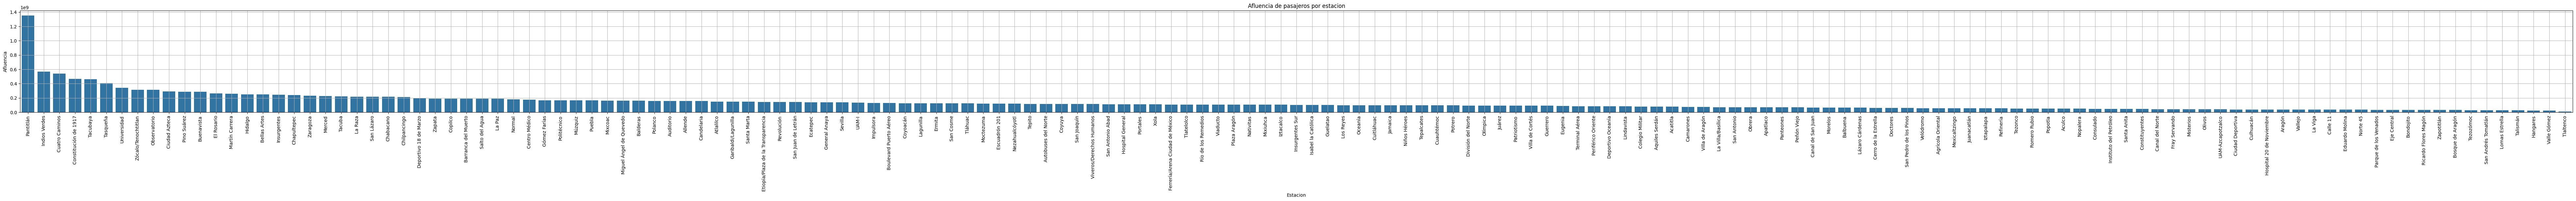

In [159]:
plt.figure(figsize=(100, 4))
sns.barplot(x = afluencia_por_estacion['estacion'], y = afluencia_por_estacion['afluencia_total'])
plt.title('Afluencia de pasajeros por estacion')
plt.xlabel('Estacion')
plt.ylabel('Afluencia')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [168]:
# --- Celda Final: Guardar Resúmenes (desde DataFrames de PANDAS) en CSV ---
import pandas as pd # Asegúrate de que pandas esté importado

print("="*50)
print("GENERANDO ARCHIVOS CSV DE RESUMEN (DESDE DATAFRAMES DE PANDAS)")
print("="*50)

# Asumiendo que las siguientes variables YA existen y son DataFrames de PANDAS:
# - afluencia_por_anio
# - afluencia_por_linea
# - promedio_total_por_mes_filtrado_pandas
# - afluencia_por_estacion

# 1. Guardar Afluencia por Año
try:
    output_file_anio = "resumen_afluencia_anio.csv"
    print(f"\n[1/4] Guardando: Afluencia por Año (Pandas) -> {output_file_anio}")
    afluencia_por_anio.to_csv(output_file_anio, index=False, encoding='utf-8-sig')
    # index=False evita que se guarde el índice del DataFrame como una columna
    # encoding='utf-8-sig' ayuda a que Excel abra bien los acentos/ñ
    print(f"    ... Guardado exitosamente.")
except NameError:
    print("ERROR: Variable 'afluencia_por_anio' no definida.")
except AttributeError:
    print("ERROR: 'afluencia_por_anio' no parece ser un DataFrame de Pandas (no tiene '.to_csv()').")
except Exception as e:
    print(f"ERROR al guardar resumen por año: {e}")

# 2. Guardar Afluencia por Línea
try:
    output_file_linea = "resumen_afluencia_linea.csv"
    print(f"\n[2/4] Guardando: Afluencia por Línea (Pandas) -> {output_file_linea}")
    afluencia_por_linea.to_csv(output_file_linea, index=False, encoding='utf-8-sig')
    print(f"    ... Guardado exitosamente.")
except NameError:
    print("ERROR: Variable 'afluencia_por_linea' no definida.")
except AttributeError:
    print("ERROR: 'afluencia_por_linea' no parece ser un DataFrame de Pandas.")
except Exception as e:
    print(f"ERROR al guardar resumen por línea: {e}")

# 3. Guardar Promedio Mensual (Filtrado)
try:
    output_file_mes = "resumen_promedio_mes_ex_covid.csv"
    print(f"\n[3/4] Guardando: Promedio Mensual (ex-COVID) (Pandas) -> {output_file_mes}")
    # Nota: Tu variable ya tenía '_pandas' en el nombre, ¡eso ayuda!
    promedio_total_por_mes_filtrado_pandas.to_csv(output_file_mes, index=False, encoding='utf-8-sig')
    print(f"    ... Guardado exitosamente.")
except NameError:
    print("ERROR: Variable 'promedio_total_por_mes_filtrado_pandas' no definida.")
except AttributeError:
    print("ERROR: 'promedio_total_por_mes_filtrado_pandas' no parece ser un DataFrame de Pandas.")
except Exception as e:
    print(f"ERROR al guardar resumen promedio mensual: {e}")

# 4. Guardar Afluencia por Estación
try:
    output_file_estacion = "resumen_afluencia_estacion.csv"
    print(f"\n[4/4] Guardando: Afluencia por Estación (Pandas) -> {output_file_estacion}")
    # Puedes ordenar el DF de Pandas ANTES de guardarlo si quieres un ranking
    # ej: afluencia_por_estacion_sorted = afluencia_por_estacion.sort_values('afluencia_total', ascending=False)
    # afluencia_por_estacion_sorted.to_csv(output_file_estacion, index=False, encoding='utf-8-sig')
    afluencia_por_estacion.to_csv(output_file_estacion, index=False, encoding='utf-8-sig')
    print(f"    ... Guardado exitosamente.")
except NameError:
    print("ERROR: Variable 'afluencia_por_estacion' no definida.")
except AttributeError:
    print("ERROR: 'afluencia_por_estacion' no parece ser un DataFrame de Pandas.")
except Exception as e:
    print(f"ERROR al guardar resumen por estación: {e}")

print("\n" + "="*50)
print("¡Proceso de guardado de resúmenes CSV (desde Pandas) completado!")
print("="*50)

GENERANDO ARCHIVOS CSV DE RESUMEN (DESDE DATAFRAMES DE PANDAS)

[1/4] Guardando: Afluencia por Año (Pandas) -> resumen_afluencia_anio.csv
    ... Guardado exitosamente.

[2/4] Guardando: Afluencia por Línea (Pandas) -> resumen_afluencia_linea.csv
    ... Guardado exitosamente.

[3/4] Guardando: Promedio Mensual (ex-COVID) (Pandas) -> resumen_promedio_mes_ex_covid.csv
    ... Guardado exitosamente.

[4/4] Guardando: Afluencia por Estación (Pandas) -> resumen_afluencia_estacion.csv
    ... Guardado exitosamente.

¡Proceso de guardado de resúmenes CSV (desde Pandas) completado!
Puedes encontrar los archivos .csv directamente en el panel de Archivos de Colab.


In [171]:
df2 =pd.read_csv('/content/Reporte - resumen_afluencia_anio.csv')
df2

,anio,sum(afluencia),linea,afluencia_total,mes_numero,promedio_afluencia_total_diaria,estacion,afluencia_total.1
0,2010.0,1.530249e+09,Linea 1,3.090889e+09,1.0,3843651.910,Pantitlán,1353560409
1,2011.0,1.594904e+09,Linea 2,3.779407e+09,2.0,4122280.347,Indios Verdes,568150097
2,2012.0,1.608865e+09,Linea 3,3.148400e+09,3.0,4012611.277,Cuatro Caminos,539924090
3,2013.0,1.684937e+09,Linea 4,4.124223e+08,4.0,4002967.869,Constitución de 1917,464611819
4,2014.0,1.614334e+09,Linea 5,1.094295e+09,5.0,4148121.697,Tacubaya,459622241
...,...,...,...,...,...,...,...,...
158,NaN,NaN,NaN,NaN,NaN,NaN,Lomas Estrella,27926656
159,NaN,NaN,NaN,NaN,NaN,NaN,Talismán,27645753
160,NaN,NaN,NaN,NaN,NaN,NaN,Hangares,25737912
161,NaN,NaN,NaN,NaN,NaN,NaN,Valle Gómez,22597938
